# **Import Libraries**

In [1]:
! pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

2025-10-08 16:16:07.760497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759940168.014212      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759940168.084277      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Exploratory Data Analysis - EDA**

In [3]:
df_train=pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')

In [4]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
print(f"df.shape={df_train.shape}")
print(f"df.columns={df_train.shape[1]}")
print(f"df.rows={df_train.shape[0]}")

df.shape=(74681, 4)
df.columns=4
df.rows=74681


In [7]:
df_train.columns = ['TweetID', 'Entity', 'Sentiment', 'Tweet_Content']

In [8]:
df_train['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

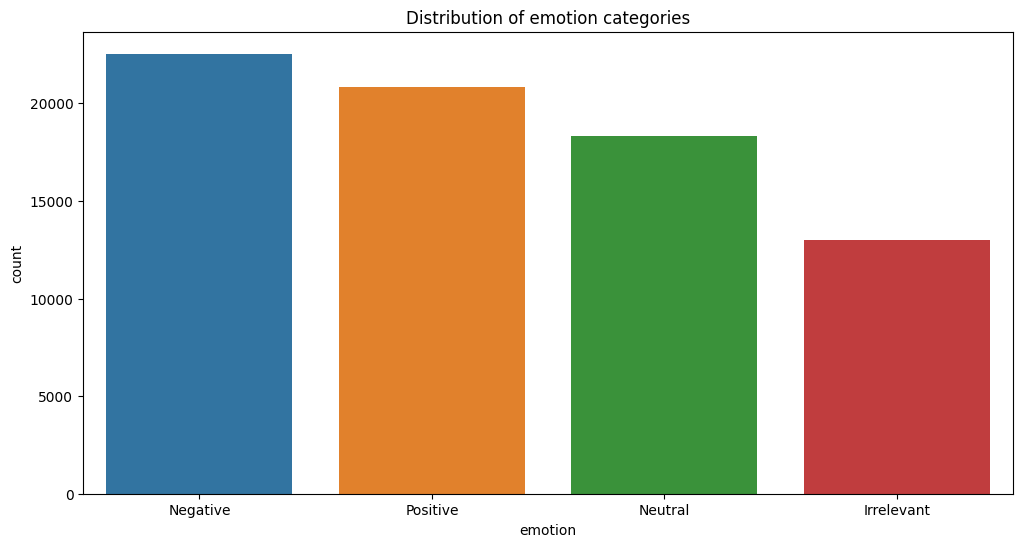

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='Sentiment', order=df_train['Sentiment'].value_counts().index)
plt.title('Distribution of emotion categories')
plt.xlabel('emotion')
plt.ylabel('count')
plt.show()

In [10]:
df_train.dropna(subset=['Tweet_Content'],inplace=True)

In [11]:
df_train['text_length']=df_train['Tweet_Content'].apply(len)

In [12]:
df_train['text_length'].describe().T

count    73995.000000
mean       108.784404
std         79.524485
min          1.000000
25%         47.000000
50%         91.000000
75%        153.000000
max        957.000000
Name: text_length, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


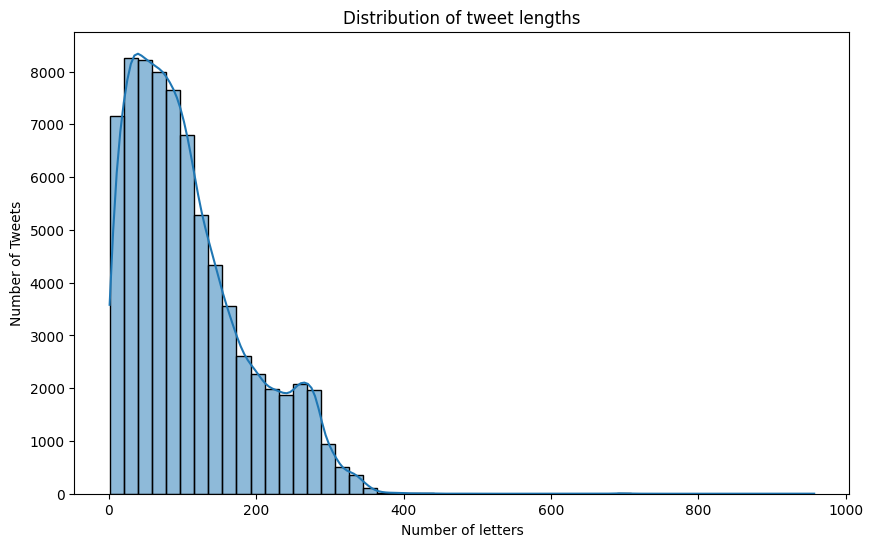

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50,kde=True)
plt.title('Distribution of tweet lengths')
plt.xlabel('Number of letters')
plt.ylabel('Number of Tweets')
plt.show()

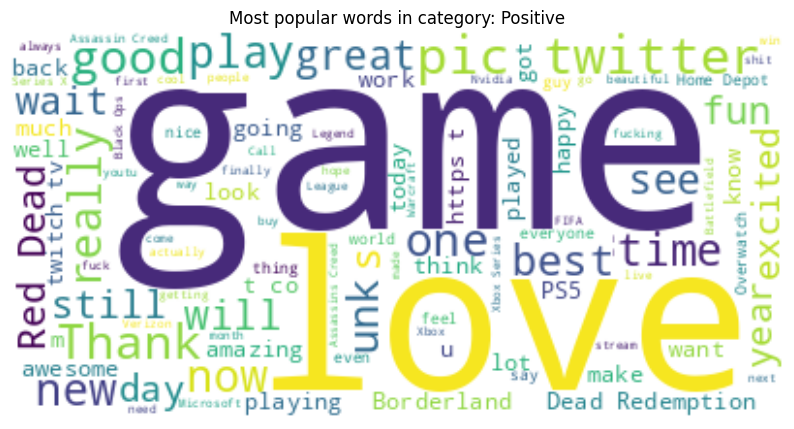

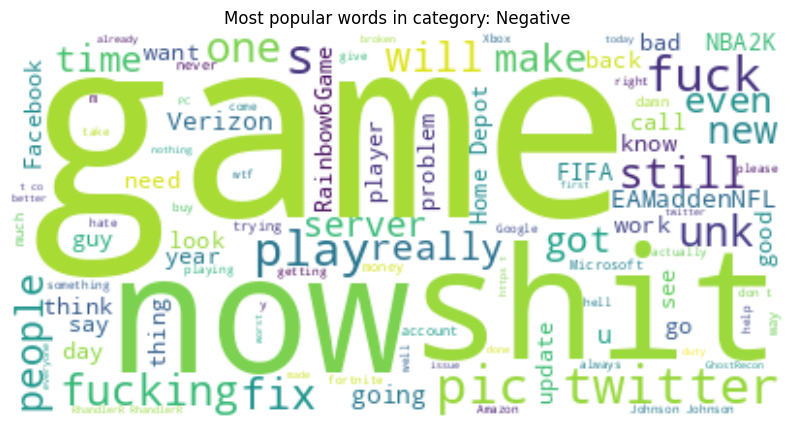

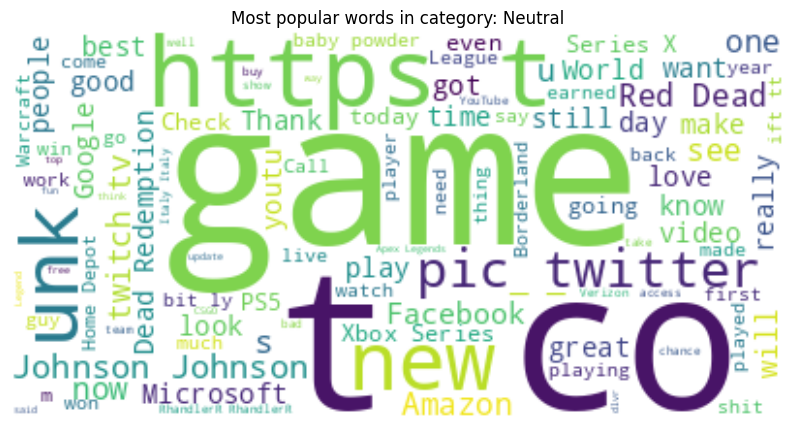

In [14]:
def generate_wordcloud(sentiment_category):
    text = ' '.join(review for review in df_train[df_train['Sentiment'] == sentiment_category]['Tweet_Content'])
    wordcloud = WordCloud(max_words=100, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most popular words in category: {sentiment_category}')
    plt.show()
generate_wordcloud('Positive')
generate_wordcloud('Negative')
generate_wordcloud('Neutral')

# **Preprocessing**

## **Text cleaning**

In [15]:
df_test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', header=None)
df_test.columns = ['TweetID', 'Entity', 'Sentiment', 'Tweet_Content']
df_test = df_test[df_test['Sentiment'] != 'Irrelevant']
df_train = df_train[df_train['Sentiment'] != 'Irrelevant']

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['label'] = label_encoder.transform(df_test['Sentiment'])

In [17]:
df_train.dropna(inplace=True)

In [18]:
df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

In [19]:
X_test=df_test['Tweet_Content']
y_test=df_test['label']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train['Tweet_Content'], 
    df_train['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=df_train['label'] 
)

In [21]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [22]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [23]:
X_train_clean = X_train.apply(clean_text)
X_val_clean = X_val.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

In [24]:
X_train_clean.iloc[0]

'tylenol cold head consumer on freedom tylenolcom products tylen mcneil consumer healthcare mcneilppc inc johnson johnson consumer inc all rights reserved tylenol https wwwco urrxmlpm'

## **Tokenization & Padding**

In [25]:
MAX_LENGTH=df_train['text_length'].max()
OOV_TOKEN='<UNK>'
VOCAB_SIZE = 15000

In [26]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train_clean)
actual_vocab_size = len(tokenizer.word_index) + 1 

In [27]:
train_sequences = tokenizer.texts_to_sequences(X_train_clean)
val_sequences = tokenizer.texts_to_sequences(X_val_clean)
test_sequences = tokenizer.texts_to_sequences(X_test_clean)

In [28]:
X_train_padded = pad_sequences(train_sequences, padding='post', maxlen=MAX_LENGTH, truncating='post')
X_val_padded = pad_sequences(val_sequences, padding='post', maxlen=MAX_LENGTH, truncating='post')
X_test_padded = pad_sequences(test_sequences, padding='post', maxlen=MAX_LENGTH, truncating='post')

In [29]:
print(f"Shape of padded training data: {X_train_padded.shape}")
print(f"Shape of padded validation data: {X_val_padded.shape}")
print(f"Shape of padded test data: {X_test_padded.shape}")
print("\nExample of a padded sequence:")
print(X_train_padded[0])

Shape of padded training data: (48896, 957)
Shape of padded validation data: (12224, 957)
Shape of padded test data: (828, 957)

Example of a padded sequence:
[ 2469   310   831  1774    14  2470     1   614 13245  6800  1774  2669
 13246  1138    48    48  1774  1138    27  2592  5786  2469   270  1854
     1     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

# **Model**

In [30]:
model = Sequential([
    Embedding(input_dim=actual_vocab_size, output_dim=128, input_length=MAX_LENGTH, mask_zero=True),
    LSTM(64),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-10-08 16:16:32.467998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(
    X_train_padded, y_train,
    epochs=5,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/5
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 744s 484ms/step - accuracy: 0.6551 - loss: 0.7867 - val_accuracy: 0.8099 - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 2/5
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 741s 485ms/step - accuracy: 0.8720 - loss: 0.3358 - val_accuracy: 0.8577 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 3/5
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 742s 485ms/step - accuracy: 0.9142 - loss: 0.2218 - val_accuracy: 0.8743 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 4/5
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 772s 505ms/step - accuracy: 0.9354 - loss: 0.1615 - val_accuracy: 0.8834 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 5/5
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 741s 485ms/step - accuracy: 0.9436 - loss: 0.1362 - val_accuracy: 0.8817 - val_loss: 0.3441 - learning_rate: 0.0010


In [34]:
model.load_weights('/kaggle/working/best_model.keras')

In [36]:
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"Test Accuracy: {accuracy*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9592 - loss: 0.1698
Test Accuracy: 95.65%


In [37]:
loss, accuracy = model.evaluate(X_train_padded, y_train, verbose=1)
print(f"Train Accuracy: {accuracy*100:.2f}%")

1528/1528 ━━━━━━━━━━━━━━━━━━━━ 219s 143ms/step - accuracy: 0.9511 - loss: 0.1196
Train Accuracy: 95.11%
